In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import NearestNeighbors

In [141]:
# Task 1: Implement a numerical solver for the Lorenz system
# Validate that your numerical implementation produces the expected behavior and is numerically converged.
class Lorenz:
    def __init__(self,parms=(10,28,8/3)):
        self.parms=parms
    
    def lorenz_sys(self,t,X):
        sigma, r, b = self.parms
        x,y,z = X
        dxdt = sigma*(y - x)
        dydt = r*x - y - x*z
        dzdt = x*y - b*z
        return [dxdt, dydt, dzdt]

    def simulate(self,n ,t_max = 100, X0 = np.array([1, 1, 1])):
        t_vec = np.linspace(0,t_max,n,endpoint=False)
        sol = sp.integrate.solve_ivp(self.lorenz_sys,[0,t_max],X0,t_eval=t_vec)
        x, y, z = sol.y
        return x, y, z, sol.t

In [155]:
class Russian:
    def __init__(self,beta_xy = 0.0, beta_yx = 0.32, r_x = 3.7, r_y = 3.7, k=0):
        self.beta=[beta_xy, beta_yx]
        self.r=[r_x,r_y]
        self.k=k
    def simulate(self,n):
        beta_xy, beta_yx = self.beta
        r_x, r_y = self.r
        sol=np.zeros((2,n))
        sol[:,0]=np.array([0.2,0.4])
        k=self.k
        for t in range(n-1):
            sol[0,t+1] = sol[0,t] * ((1+k*np.sin(t))*r_x - r_x*sol[0,t] - beta_xy*sol[1,t])
            sol[1,t+1] = sol[1,t] * ((1+k*np.sin(t))*r_y - r_y*sol[1,t] - beta_yx*sol[0,t])
        return sol[0,:], sol[1,:]

In [12]:
def shadowmanifold(x, e, tau=1):
    X = []
    n = len(x)
    for i in range(e):
        X.append(x[tau*i:tau*i+(n-(e-1)*tau)])
    return np.array(X).T

In [13]:
def CCM(N, system,tau=1,dir=1,output=0,k=0):
    if system == 'Russian':
        sim = Russian(k=k)
        x,y = sim.simulate(n=N)
        e=2
    elif system == 'Lorenz':
        sim = Lorenz()
        x, y, z, t = sim.simulate(n=N)
        e=3
    if dir==-1:
        x, y = y, x
    Xsm = shadowmanifold(x,e,tau=tau)
    if output==1:
        fig = plt.figure()
        if system == 'Russian':
            ax = plt.axes()
            _ = ax.scatter(Xsm[:,0],Xsm[:,1])
        elif system == 'Lorenz':
            ax = plt.axes(projection='3d')
            _ = ax.plot3D(Xsm[:,0],Xsm[:,1],Xsm[:,2])
    
    nbrs = NearestNeighbors(n_neighbors=e+2, algorithm='ball_tree').fit(Xsm)
    distances, indices = nbrs.kneighbors(Xsm)
    distances=distances[:,1:]
    indices=indices[:,1:]
    
    mindist=distances[:,0][...,None]
    p=np.exp(-distances/mindist)
    weights=p/np.sum(p,axis=1)[...,None]
    
    Yhat=np.sum(weights*y[indices],axis=1)
    return y[:-(e-1)*tau], Yhat, sp.stats.pearsonr(Yhat,y[:-(e-1)*tau])[0]

### Main

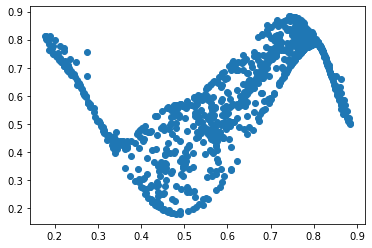

In [183]:
y, yhat, r = CCM(N=1000,system='Russian',tau=2,dir=-1,output=1,k=0.0)

Pearson corr is  0.9665397053507365


(998,)

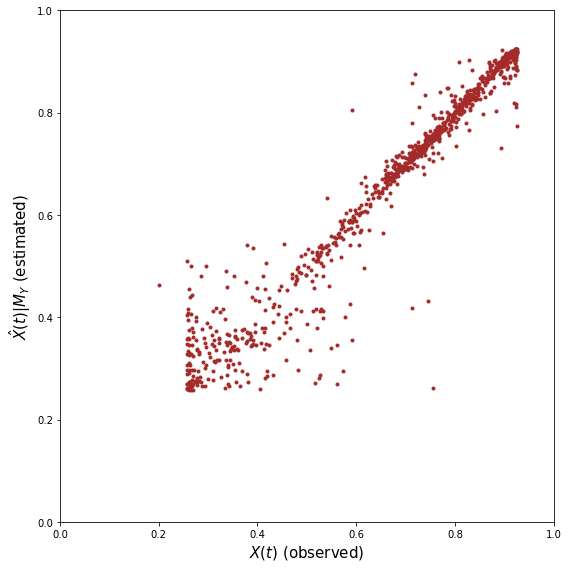

In [101]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(y, yhat,marker='.',c='brown')
ax.set_xlabel(r"$X(t)$ (observed)",fontsize=15)
ax.set_ylabel(r"$\hat{X}(t)|M_Y$ (estimated)",fontsize=15)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
fig.tight_layout()
fig.savefig('ps.jpeg')
print('Pearson corr is ', r)
y.shape

In [181]:
N = np.arange(2,61)*50
r1=[]
r2=[]
for n in N:
    y, yhat, r = CCM(N=n,system='Russian',tau=1,dir=1)
    r1.append(r)
    y, yhat, r = CCM(N=n,system='Russian',tau=1,dir=-1)
    r2.append(r)

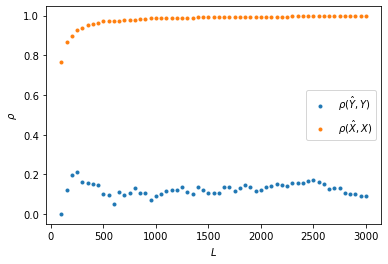

In [182]:
plt.scatter(N, r1,marker='.')
plt.scatter(N, r2,marker='.')
plt.ylabel(r'$\rho$')
plt.xlabel(r'$L$')
plt.legend([r'$\rho(\hat{Y},Y)$',r'$\rho(\hat{X},X$)'])
plt.savefig('p2.jpeg')

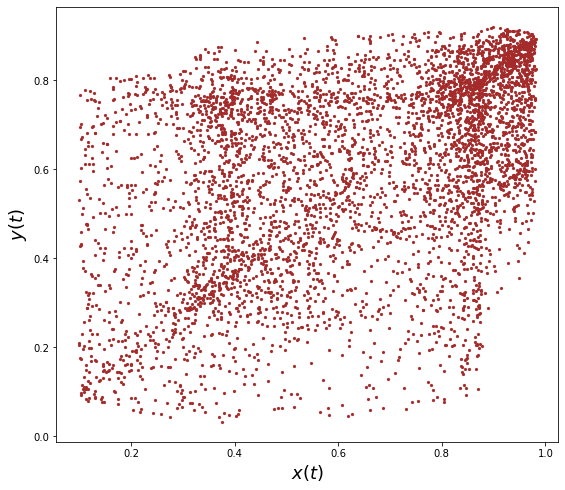

In [136]:
russ = Russian(k=0.03)
x, y = russ.simulate(n=5000)
e=2
tau=2
fig,ax = plt.subplots(1,1,figsize = (9,8))
#ax = plt.axes(projection='3d')
#_ = ax.plot3D(x,y,z)
_ = ax.scatter(x,y, c = 'brown', linewidth = 0.2, marker='.')
_ = ax.set_xlabel(f"$x(t)$", fontsize = 18)
_ = ax.set_ylabel(f"$y(t)$", fontsize = 18)
plt.show()
fig.tight_layout()
fig.savefig('n1.jpeg')

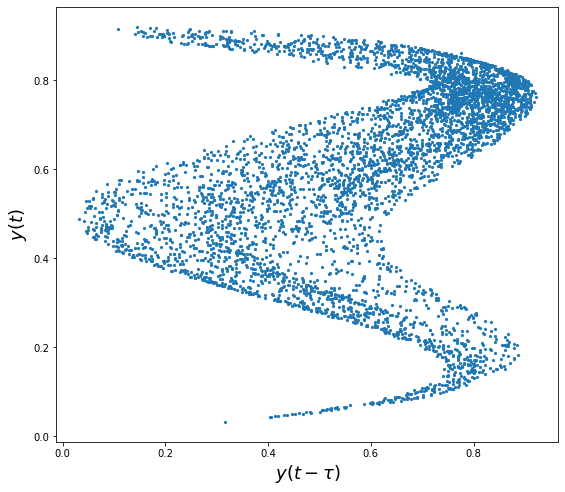

In [137]:
Xsm = shadowmanifold(y,e,tau=tau)
fig,ax = plt.subplots(1,1,figsize = (9,8))
#ax = plt.axes(projection='3d')
#_ = ax.plot3D(x,y,z)
_ = ax.scatter(Xsm[:,1],Xsm[:,0], linewidth = 0.2, marker='.')
_ = ax.set_xlabel(r"$y(t-\tau)$", fontsize = 18)
_ = ax.set_ylabel(r"$y(t)$", fontsize = 18)
plt.show()
fig.tight_layout()
fig.savefig('n2.jpeg')

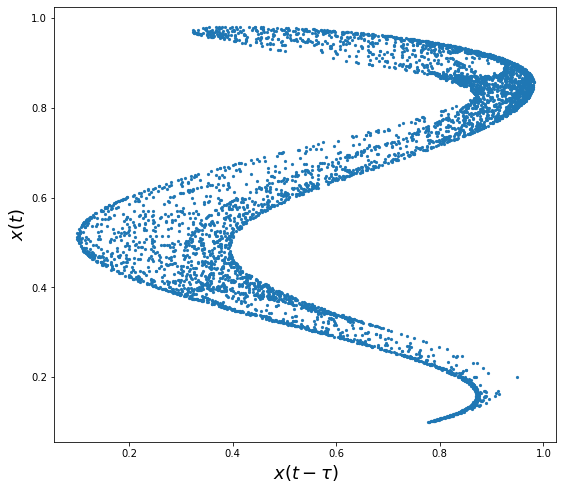

In [138]:
Xsm = shadowmanifold(x,e,tau=tau)
fig,ax = plt.subplots(1,1,figsize = (9,8))
#ax = plt.axes(projection='3d')
#_ = ax.plot3D(x,y,z)
_ = ax.scatter(Xsm[:,1],Xsm[:,0], linewidth = 0.2, marker='.')
_ = ax.set_xlabel(r"$x(t-\tau)$", fontsize = 18)
_ = ax.set_ylabel(r"$x(t)$", fontsize = 18)
plt.show()
fig.tight_layout()
fig.savefig('n3.jpeg')

In [185]:
t3[10]

NameError: name 't3' is not defined

### Testing Stuff

IndexError: index 2 is out of bounds for axis 1 with size 2

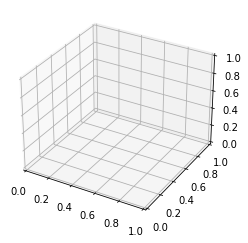

In [184]:
fig = plt.figure()
ax = plt.axes(projection='3d')
#_ = ax.plot3D(x,y,z)
_ = ax.plot3D(Xsm[:,0],Xsm[:,1],Xsm[:,2])